# 07. bonniema/salary-predictor

## Model 6: Mixed Input Model with City, Rate Type and Cost of Living Indexes

## Import libraries and the final salary dataset

In [79]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn
from keras.initializers import Constant

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
salary_df = pd.read_csv('salary_final_2.csv')

In [81]:
print(salary_df.shape)
# salary_df.drop('Unnamed: 0.2', axis=1, inplace=True)
salary_df.drop('Unnamed: 0.1', axis=1, inplace=True)
salary_df.drop('Unnamed: 0', axis=1, inplace=True)
salary_df.head()

(963, 27)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,City_Bins,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Business Data Quality Engineer Please note tha...,3


In [82]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           963 non-null    object 
 1   Company                         963 non-null    object 
 2   Link                            963 non-null    object 
 3   Review                          963 non-null    object 
 4   Salary                          963 non-null    object 
 5   Description                     963 non-null    object 
 6   Location2                       958 non-null    object 
 7   Rate_by                         963 non-null    object 
 8   low                             963 non-null    object 
 9   high                            762 non-null    object 
 10  min                             963 non-null    float64
 11  max                             963 non-null    float64
 12  adjusted_salary                 963 

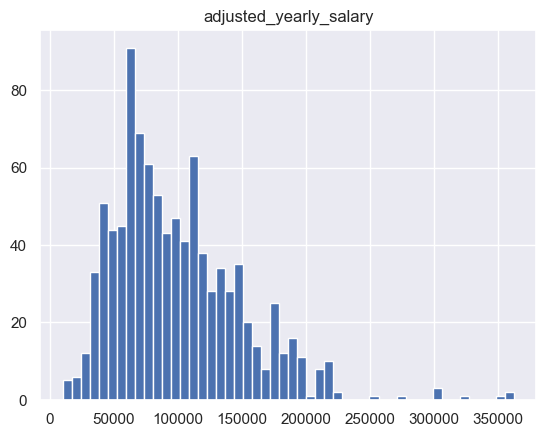

In [152]:
salary_df.hist('adjusted_yearly_salary', bins=50)
# plt.grid(axis='both')
plt.show()

In [84]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [85]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [86]:
salary_df['Salary_Bins']

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: int64

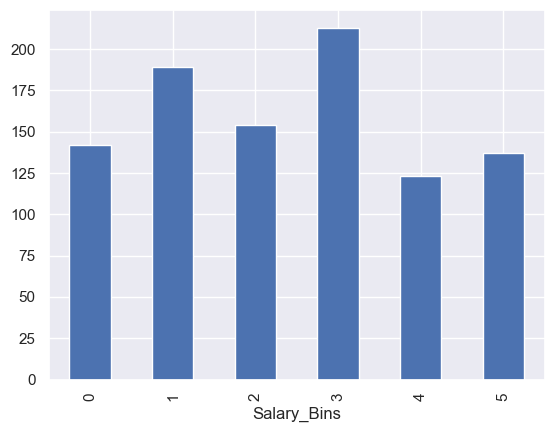

In [87]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [88]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [89]:
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [90]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [91]:
data = clean_word(salary_df['combined_text'])

In [92]:
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

## Model 6: Mixed Input Model with City, Rate Type and Cost of Living Indexes

Use Functional API:  https://machinelearningmastery.com/keras-functional-api-deep-learning/

Multi-input full example: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [93]:
# Let's explore continuous and categorical variables
salary_df.head()

,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,City_Bins,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,medium,Business Data Quality Engineer Please note tha...,3


In [94]:
cont_features = ['Cost of Living Index','Rent Index','Cost of Living Plus Rent Index','Local Purchasing Power Index']
X_cont_df = salary_df.loc[:, cont_features]

In [95]:
X_cont_df

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,80.159143,58.838571,69.961143,115.594571
1,80.159143,58.838571,69.961143,115.594571
2,80.159143,58.838571,69.961143,115.594571
3,80.159143,58.838571,69.961143,115.594571
4,80.159143,58.838571,69.961143,115.594571
...,...,...,...,...
958,87.740000,78.180000,83.170000,130.250000
959,87.740000,78.180000,83.170000,130.250000
960,87.740000,78.180000,83.170000,130.250000
961,87.740000,78.180000,83.170000,130.250000


In [96]:
X_cont_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cost of Living Index            939 non-null    float64
 1   Rent Index                      939 non-null    float64
 2   Cost of Living Plus Rent Index  939 non-null    float64
 3   Local Purchasing Power Index    939 non-null    float64
dtypes: float64(4)
memory usage: 30.2 KB


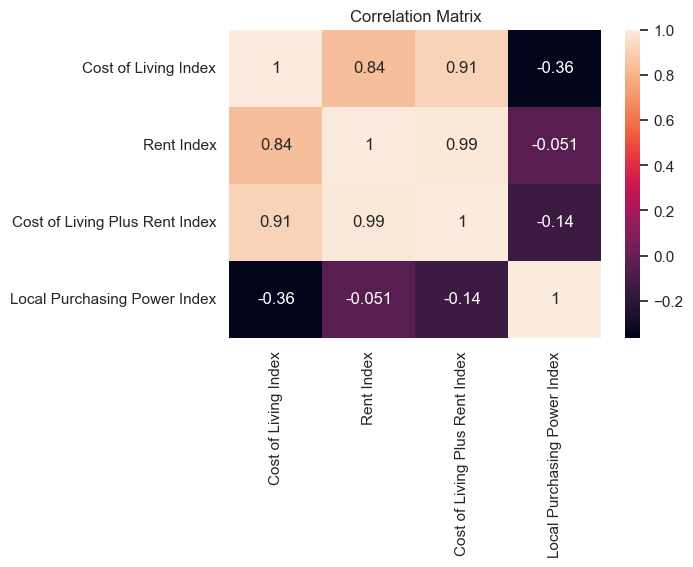

In [97]:
# Look at the correlation among continous variables
np.random.seed(0)
sns.set()
plt.figure(figsize=(6,4))
ax = sns.heatmap(X_cont_df.corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

It looks like 'Cost of Living Index' largely corralates with 'Rent Index' and negatively corralates with 'Local Purchasing Power Index'. In this model, we'll keep 'Cost of Living Plus Rent Index' and 'Local Purchasing Power Index'.

In [98]:
# Keep 'Cost of Living Plus Rent Index', 'Local Purchasing Power Index' and fill missing values with the mean
cont_imp = SimpleImputer(strategy='mean')
cont_imp.fit(X_cont_df[['Cost of Living Plus Rent Index','Local Purchasing Power Index']])
X_cont = cont_imp.transform(X_cont_df[['Cost of Living Plus Rent Index','Local Purchasing Power Index']])

# Standardize inputs
sc=StandardScaler()
sc.fit(X_cont)
X_cont_scaled = sc.transform(X_cont)

# Continous Features Dataframe
cont_scaled_df = pd.DataFrame(X_cont_scaled, columns = ['Cost of Living Plus Rent Index','Local Purchasing Power Index'])

In [99]:
cont_scaled_df.head()

,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,-0.393615,-0.604979
1,-0.393615,-0.604979
2,-0.393615,-0.604979
3,-0.393615,-0.604979
4,-0.393615,-0.604979


In [100]:
# Also try unscaled Index
con_unscaled_df = pd.DataFrame(X_cont_df, columns = ['Cost of Living Plus Rent Index','Local Purchasing Power Index'])

In [101]:
con_unscaled_df.head()

,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,69.961143,115.594571
1,69.961143,115.594571
2,69.961143,115.594571
3,69.961143,115.594571
4,69.961143,115.594571


In [102]:
con_unscaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cost of Living Plus Rent Index  939 non-null    float64
 1   Local Purchasing Power Index    939 non-null    float64
dtypes: float64(2)
memory usage: 15.2 KB


In [103]:
salary_df['City'].unique()

array(['Arlington, VA', 'Atlanta, GA', nan, 'Austin, TX', 'Boston, MA',
       'Cambridge, MA', 'Charlotte, NC', 'Chicago, IL', 'Dallas, TX',
       'Denver, CO', 'Hartford, CT', 'Houston, TX', 'Irving, TX',
       'Los Angeles, CA', 'New York, NY', 'Palo Alto, CA',
       'Philadelphia, PA', 'Pittsburg, PA', 'Portland, OR',
       'Raleigh-Durham, NC', 'San Antonio, TX', 'San Francisco, CA',
       'San Jose, CA', 'Seattle, WA', 'Washington, DC'], dtype=object)

In [104]:
salary_df['City_Bins'] = salary_df['City_Bins'].astype('category')

In [105]:
salary_df['City_Bins'].value_counts()

low       363
high      294
medium    282
Name: City_Bins, dtype: int64

In [106]:
salary_df['Rate_by'].unique()

array(['Yearly', 'Hourly', 'Monthly', 'Daily'], dtype=object)

In [107]:
# Categorical Features
cat_features = ['Rate_by','City_Bins']
X_cat = salary_df.loc[:, cat_features]

# Replace NaNs with 'missing'
cat_imp = SimpleImputer(strategy='constant', fill_value='missing')
cat_imp.fit(X_cat)
X_cat = cat_imp.transform(X_cat)

# Encode Categorical Features
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

# Create categorical features dataframe
cat_df = pd.DataFrame(X_cat_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
cat_df.describe()

,Rate_by_Daily,Rate_by_Hourly,Rate_by_Monthly,Rate_by_Yearly,City_Bins_high,City_Bins_low,City_Bins_medium,City_Bins_missing
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000
mean,0.001038,0.305296,0.032191,0.661475,0.305296,0.376947,0.292835,0.024922
std,0.032225,0.460772,0.176599,0.473454,0.460772,0.484873,0.455300,0.155969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
# cat_df['City_Bins']= salary_df['City_Bins']
# Drop Rate_by_Daily and City_Bins_missing since too many zeros
cat_df_clean = cat_df.drop(['Rate_by_Daily', 'City_Bins_missing'], axis=1)

In [110]:
# Combine continuous and categorical variables into one data frame
# Other_inputs = pd.concat([cont_scaled_df, cat_df], axis=1)
Other_inputs = pd.concat([cont_scaled_df, cat_df_clean], axis=1)

In [111]:
Other_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cost of Living Plus Rent Index  963 non-null    float64
 1   Local Purchasing Power Index    963 non-null    float64
 2   Rate_by_Hourly                  963 non-null    float64
 3   Rate_by_Monthly                 963 non-null    float64
 4   Rate_by_Yearly                  963 non-null    float64
 5   City_Bins_high                  963 non-null    float64
 6   City_Bins_low                   963 non-null    float64
 7   City_Bins_medium                963 non-null    float64
dtypes: float64(8)
memory usage: 60.3 KB


In [113]:
# Text inputs - embedding layer
tokenizer = text.Tokenizer() 
tokenizer.num_words = 1000    # Limit the number of words to keep most common 1000 words
tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = tokenizer.texts_to_sequences(salary_df['combined_text'])

X_t = pad_sequences(list_tokenized_jd, maxlen=500, padding = 'post') 

In [114]:
X_t

array([[  6, 509,   7, ..., 227, 111, 893],
       [  9,  69,   9, ...,   0,   0,   0],
       [ 49,   1, 568, ...,   2, 305, 281],
       ...,
       [151,  97, 151, ...,   0,   0,   0],
       [ 62,  47, 806, ...,   0,   0,   0],
       [416, 460, 789, ...,   0,   0,   0]])

In [115]:
y = to_categorical(target_class.values, num_classes=6, dtype="float32")

In [116]:
y

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [119]:
# Train Test split on text inputs use Keras embedding layer
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=4)

In [120]:
# Train Test split on other inputs
X2_train, X2_test, y2_train, y2_test = train_test_split(Other_inputs, y, test_size=0.1, random_state=4)

In [123]:
print(X_train.shape, X2_train.shape, X_test.shape, X2_test.shape)

(866, 500) (866, 8) (97, 500) (97, 8)


In [124]:
print(y_train.shape, y2_train.shape, y_test.shape, y2_test.shape)

(866, 6) (866, 6) (97, 6) (97, 6)


In [125]:
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

### Put them together

In [126]:
# Define two sets of inputs
inputA = Input(shape=(8,)) # non-words input
inputB = Input(shape=(500,))  # word vectors 

# The first branch operates on the first input
# hiddenA1 = Dense(16, activation="relu")(inputA)
# hiddenA2 = Dense(16, activation="relu")(hiddenA1)
outputA = Dense(4, activation="relu")(inputA)
modelA = Model(inputs=inputA, outputs=outputA)

# The second branch opreates on the second input
# Each word onto a 32 length real valued vector
embedB1 =  Embedding(input_dim = 1000, output_dim = 32, input_length = 500)(inputB) 
convB1 = Conv1D(filters=32, kernel_size = 3, padding='same', activation='relu')(embedB1)
poolB1 = MaxPooling1D(pool_size=2)(convB1)
LSTMB1 = LSTM(128, return_sequences=True)(poolB1)
hiddenB1 = Dense(100, activation='relu')(LSTMB1)
dropB1 = Dropout(0.5)(hiddenB1)
flat = Flatten()(dropB1)
outputB = Dense(128, activation='relu')(flat)
modelB = Model(inputs=inputB, outputs=outputB)

# Combine the output of the two branches
combined = concatenate([modelA.output, modelB.output])
# apply a FC layer and then a regression prediction on the combined outputs
z = Dense(16, activation="relu")(combined)
z = Dense(6, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[modelA.input, modelB.input], outputs=z)

In [127]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 32)      32000       ['input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 32)      3104        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 250, 32)      0           ['conv1d[0][0]']                 
                                                                                            

In [128]:
opt = Adam(lr=1e-3, decay=1e-3/200)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
es = EarlyStopping(monitor='val_loss', patience = 10, mode='min', verbose=1)
history = model.fit([X2_train, X_train], y_train, validation_data = ([X2_test, X_test], y_test), 
                    epochs=40, batch_size=128, callbacks=[es])

Epoch 1/40


C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 5s 541ms/step - loss: 1.7974 - accuracy: 0.1940 - val_loss: 1.7816 - val_accuracy: 0.1856
Epoch 2/40
7/7 [==============================] - 3s 478ms/step - loss: 1.7903 - accuracy: 0.1755 - val_loss: 1.7854 - val_accuracy: 0.1959
Epoch 3/40
7/7 [==============================] - 3s 505ms/step - loss: 1.7836 - accuracy: 0.2102 - val_loss: 1.7776 - val_accuracy: 0.2577
Epoch 4/40
7/7 [==============================] - 3s 496ms/step - loss: 1.7724 - accuracy: 0.2079 - val_loss: 1.7837 - val_accuracy: 0.2062
Epoch 5/40
7/7 [==============================] - 4s 570ms/step - loss: 1.7563 - accuracy: 0.2171 - val_loss: 1.7426 - val_accuracy: 0.2165
Epoch 6/40
7/7 [==============================] - 4s 545ms/step - loss: 1.7201 - accuracy: 0.2506 - val_loss: 1.6755 - val_accuracy: 0.2680
Epoch 7/40
7/7 [==============================] - 4s 554ms/step - loss: 1.6530 - accuracy: 0.2852 - val_loss: 1.6016 - val_accuracy: 0.4330
Epoch 8/40
7/7 [===============

### Try Word2Vec Embedding in Mixed Input Model

In [131]:
# Create a Word2Vec model with 100 dimensions
# vector_size = the number of dimensions of the N-dimensional space and Word2Vec maps the words into
# min_count = min frequency appeared in the corpus
w2v_model1 = Word2Vec(data, vector_size=100, window=5, min_count=3, workers=4)

In [132]:
w2v_model1.train(data,total_examples=w2v_model1.corpus_count, epochs=10)

(3184260, 3458620)

In [133]:
wv = w2v_model1.wv

In [134]:
# Save model to be used in deep learning step
filename = 'jd_embedding_word2vec2.txt'
w2v_model1.wv.save_word2vec_format(filename, binary=False)

In [135]:
# load the word embedding as a directory of words to vectors
import os
embeddings_index = {}
f = open(os.path.join('','jd_embedding_word2vec2.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [136]:
# Get the total_vocabulary in the corpus
total_vocabulary = set(word for jd in data for word in jd)
max_length = len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13262 unique tokens in the dataset.


In [137]:
# Convert the word embedding into tokenized vector. 
new_tokenizer = text.Tokenizer() 
new_tokenizer.num_words = 1000  # Limit the number of words to keep most common 1000 words
new_tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = new_tokenizer.texts_to_sequences(salary_df['combined_text'])

# Pad sequences
word_index = new_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

jd_pad = pad_sequences(list_tokenized_jd, maxlen=500, padding = 'post') 
print('Shape of the jd tensor:', jd_pad.shape)

Found 26519 unique tokens.
Shape of the jd tensor: (963, 500)


In [138]:
# Map embeddings from word2vec model for each word to new_tokenzier.word_index and create a matrix with word vectors
num_words = len(word_index)+1  # 1000  + 1
embedding_matrix = np.zeros((num_words, 100)) # Embedding size = 100
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [139]:
print(num_words)

26520


In [140]:
# X_train, X_test using pad sequences from Word2Vec model
X_train, X_test, y_train, y_test = train_test_split(jd_pad, y, test_size=0.1, random_state=4)

In [141]:
X_train

array([[114, 186, 211, ...,   0,   0,   0],
       [  9, 344, 135, ...,   0,   0,   0],
       [875, 825, 210, ...,   0,   0,   0],
       ...,
       [962,  34, 825, ...,   0,   0,   0],
       [ 15, 499,  41, ..., 169, 337, 100],
       [958, 319,  11, ...,   0,   0,   0]])

In [142]:
X_test

array([[  9,  97,  24, ...,   0,   0,   0],
       [ 16,   9,  62, ...,   0,   0,   0],
       [ 58, 137,   3, ...,   0,   0,   0],
       ...,
       [  2, 981,  49, ...,  31,  91, 641],
       [  7,   3,   4, ...,   4,  10, 159],
       [518,   6, 100, ..., 482,  57,  80]])

In [144]:
# Define two sets of inputs
inputA = Input(shape=(8,)) #non-words input
inputB = Input(shape=(500,))  #word vectors 

# The first branch operates on the first input
#hiddenA1 = Dense(16, activation="relu")(inputA)
#hiddenA2 = Dense(16, activation="relu")(hiddenA1)
outputA = Dense(4, activation="relu")(inputA)
modelA = Model(inputs=inputA, outputs=outputA)

# The second branch opreates on the second input
# Word2Vec Embedding layer
embedding_size = 100  #word2vec has a 100 dimension space
embedding_layer = Embedding(input_dim = num_words, #input_dim: size of the vocabulary
                    output_dim = embedding_size,  #dimension of the dense embedding
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length = 500, #length of input sequences
                    trainable = False)

embedded_sequences = embedding_layer(inputB)
# Each word onto a 32 length real valued vector
# embedB1 =  Embedding(input_dim = 1000, output_dim = 32, input_length = 500)(inputB) 
convB1 = Conv1D(filters=32, kernel_size = 3, padding='same', activation='relu')(embedded_sequences)
poolB1 = MaxPooling1D(pool_size=2)(convB1)
LSTMB1 = LSTM(128, return_sequences=True)(poolB1)
dropB1 = Dropout(0.5)(poolB1)
hiddenB1 = Dense(100, activation='relu')(dropB1)
dropB2 = Dropout(0.5)(hiddenB1)
flat = Flatten()(dropB2)
outputB = Dense(128, activation='relu')(flat)
modelB = Model(inputs=inputB, outputs=outputB)

# Combine the output of the two branches
combined = concatenate([modelA.output, modelB.output])
# Qpply a FC layer and then a regression prediction on the combined outputs
z = Dense(64, activation="relu")(combined)
z = Dense(32, activation="relu")(z)
z = Dense(6, activation="softmax")(z)
# Our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[modelA.input, modelB.input], outputs=z)

In [145]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 100)     2652000     ['input_4[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 32)      9632        ['embedding_1[0][0]']            
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 250, 32)     0           ['conv1d_1[0][0]']               
                                                                                            

In [146]:
opt = RMSprop(lr=1e-4)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
es = EarlyStopping(monitor='val_loss', patience = 10, mode='min', verbose=1)
history = model.fit([X2_train,X_train], y_train, validation_data = ([X2_test, X_test], y_test), 
                    epochs=40, batch_size=128, callbacks=[es])

Epoch 1/40


C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 2s 170ms/step - loss: 1.8537 - accuracy: 0.1975 - val_loss: 1.7749 - val_accuracy: 0.2680
Epoch 2/40
7/7 [==============================] - 1s 165ms/step - loss: 1.7788 - accuracy: 0.2136 - val_loss: 1.7621 - val_accuracy: 0.2371
Epoch 3/40
7/7 [==============================] - 1s 148ms/step - loss: 1.7510 - accuracy: 0.2425 - val_loss: 1.7441 - val_accuracy: 0.2680
Epoch 4/40
7/7 [==============================] - 1s 150ms/step - loss: 1.7057 - accuracy: 0.2783 - val_loss: 1.7373 - val_accuracy: 0.2577
Epoch 5/40
7/7 [==============================] - 1s 147ms/step - loss: 1.6798 - accuracy: 0.2875 - val_loss: 1.7300 - val_accuracy: 0.2784
Epoch 6/40
7/7 [==============================] - 1s 158ms/step - loss: 1.6430 - accuracy: 0.3268 - val_loss: 1.7158 - val_accuracy: 0.2784
Epoch 7/40
7/7 [==============================] - 1s 154ms/step - loss: 1.6086 - accuracy: 0.3360 - val_loss: 1.6747 - val_accuracy: 0.2784
Epoch 8/40
7/7 [===============

**Word2Vec was not able to improve the performance further...**